In [1]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
import time
import copy
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets
from sklearn.metrics import roc_curve

max_epochs=3

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)                   

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,5]).to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = model.cuda()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, chunks=9):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for chunk in range(chunks):
                X, Y = torch.load('data/images-' + str(chunk) + '.pt'),\
                       torch.load('data/labels-' + str(chunk) + '.pt')
                train = data_utils.TensorDataset(X, Y)
                train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
            
                for inputs, labels in train_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

            epoch_loss = running_loss / (chunks*2169)
            epoch_acc = running_corrects.double() / (chunks*2169)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [2]:
def get_roc_curve(preds, labels):
    '''Take torch tensors of all model outputs, all model labels
        and display an roc curve.'''
    sm = nn.Softmax()
    roc_preds = sm(preds).detach().numpy()[:,1]
    roc_labels = labels.detach().numpy()
    
    fpr, tpr, thresholds = roc_curve(roc_labels, roc_preds)
    plt.plot(fpr, tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("VGG-19 lesion classifier: ROC curve")
    plt.show()

In [3]:
def test_model(model, criterion):
    model.eval()
    X, Y = torch.load('data/images-9.pt'),\
           torch.load('data/labels-9.pt')
    running_loss = 0.0
    running_corrects = 0
    train = data_utils.TensorDataset(X, Y)
    
    all_outputs = []
    all_labels = []
    
    train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        all_outputs.append(outputs.cpu())
        all_labels.append(labels.cpu())
            
    loss = running_loss
    acc = running_corrects.double() / (len(Y))

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
        loss, acc))
    
    all_outputs = torch.cat((*all_outputs,))
    all_labels = torch.cat((*all_labels,))
    
    return all_outputs, all_labels

In [ ]:
train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10, chunks=9)

Test Loss: 10147.3051 Acc: 0.8439


/home/paperspace/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


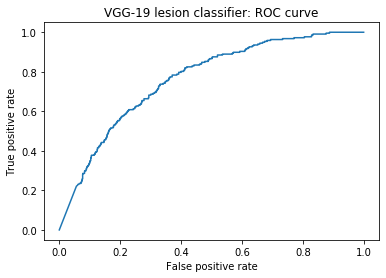

In [4]:
criterion = nn.CrossEntropyLoss()
model = torch.load('models/vgg19_83.pt')
preds, labels = test_model(model, criterion)
get_roc_curve(preds, labels)